Osnabrück University - Computer Vision (Winter Term 2019/20) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 04: Segmentation and Color

## Introduction


This week's sheet should be solved and handed in before the end of **Saturday, December 7, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

YOUR ANSWER HERE

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

YOUR ANSWER HERE

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE

## Assignment 1: Histogram-based segmentation [5 Points]

### a) Histogram-based segmentation

What is histogram-based segmentation? What are it's goals, benefits, and problems?

Its a segmentation based on the gray value distribution, where peaks of gray values in the histogram are seperated.<br>
Benefits: Easy to use, fast.<br>
Problem: Not suitable for more complex problems or even when the segments are not separable by its gray values.

### b) Threshold computation

There exist different methods to automatically determine a threshold for an image. Find at least two that are provided by scikit-image and describe them in more detail. Then apply them to the images `schrift.png` and `pebbles.jpg`.

From the package skimage.filters there are for example the threshold algorithms after the minimum method and the Mean method.<br>
Minimum: Smoothes the histogram, until just 2 peaks are left. Then takes the minimal value between the peaks.<br>
Mean: Simply takes the mean of the histogram values and takes it as a threshold. 

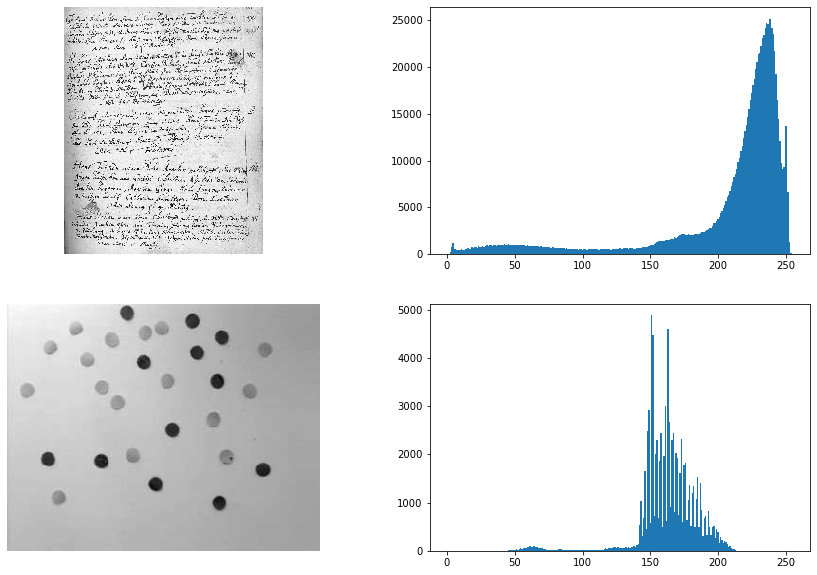

In [4]:
# Run this cell to get an impression of how the histograms look

%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread

img1 = imread('images/schrift.png')
img2 = imread('images/pebbles.jpg') 

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(img1)
plt.subplot(2,2,2)
plt.hist(img1.flatten(), 256, (0, 255))
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(img2)
plt.subplot(2,2,4)
plt.hist(img2.flatten(), 256, (0, 255))
plt.show()

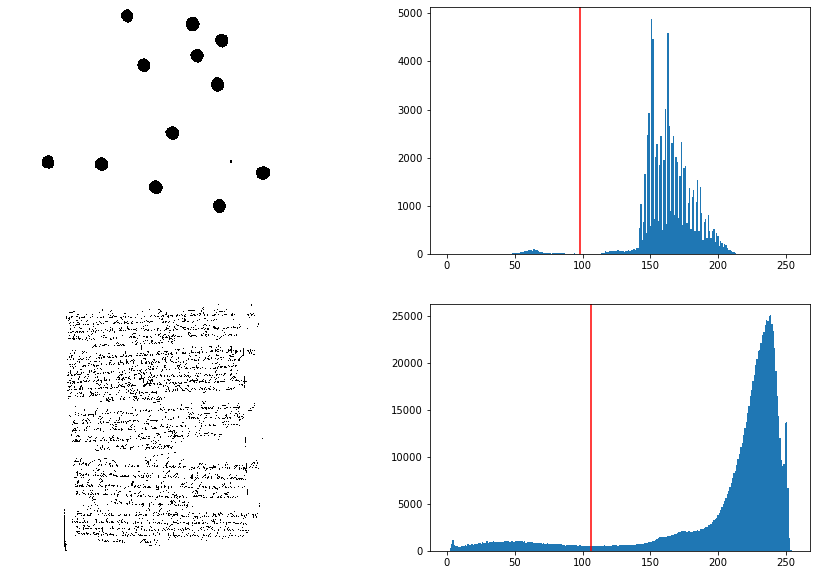

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread
from skimage.filters import threshold_minimum, threshold_mean

img1 = imread('images/pebbles.jpg') 
thresh1 = threshold_minimum(img1)
segments1 = img1 > thresh1

img2 = imread('images/schrift.png')
thresh2 = threshold_minimum(img2)
segments2 = img2 > thresh2

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(segments1)
plt.subplot(2,2,2)
plt.hist(img1.flatten(), 256, (0, 255))
plt.axvline(thresh1, color='r')
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(segments2)
plt.subplot(2,2,4)
plt.hist(img2.flatten(), 256, (0, 255))
plt.axvline(thresh2, color='r')
plt.show()

### c) Shading

Shading may cause a problem to histogram based segmentation. In the lecture (CV-07 slide 13), it was proposed to compute a shading image to deal with that problem. Apply this approach to the images `schrift.png` and `pebbles.jpg`. You may use filter functions from scikit-image for this exercise.

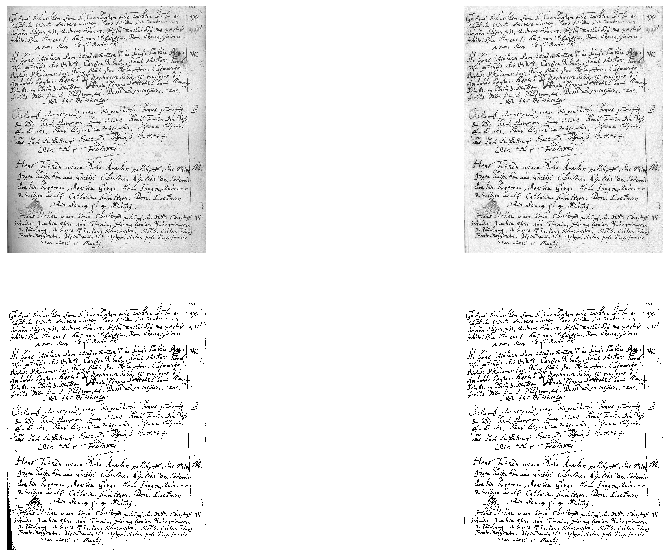

In [81]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.filters.rank import median, maximum
from skimage.filters import threshold_otsu

img = imread('images/schrift.png')
#img = imread('images/pebbles.png').astype(float)/255

thresh1 = threshold_otsu(img)

shading_img = 1 / maximum(img, np.ones((10, 10)))
corrected_img = img * shading_img
thresh2 = threshold_otsu(corrected_img)

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(img)
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(corrected_img)

plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(img > thresh1)
plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(corrected_img > thresh2)

## Assignment 2: Pyramid representation [5 Points]

**a)** What is the *Gaussian pyramid*? How does the **reduce** operation work? Explain in your own words what low pass filtering is and why it should be used when building the pyramid? Implement the **reduce** operation and generate a figure similar to the one on (CV-07 slide 32).

The gaussian pyramid is a representation of an image, that is scaled from original size to 1 pixel by halfing the width and the weight stepwise.<br>
It is done by mapping replacing 4 pixels of the image on 1 pixel.<br>
Before that, the image runs through a low-pass-filter, what smoothes the images. This reduces the frequencies of the neighboring values to reduce artifacts in the scaled image.

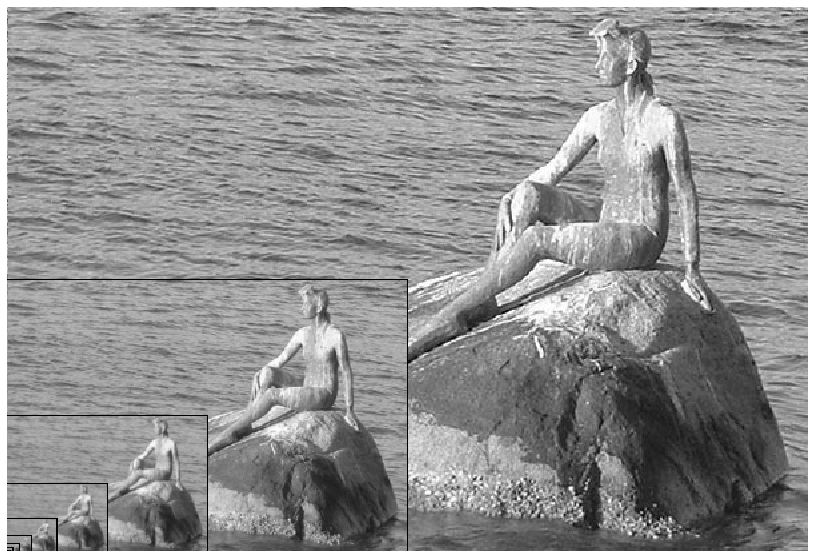

In [5]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread
from scipy.ndimage.filters import convolve

def low_pass_filter(img):
    kernel = np.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ]) / 16.0
    return convolve(img, kernel)

def resize(img):
    new_img = np.zeros((img.shape[0]//2, img.shape[1]//2))
    for x in range(new_img.shape[0]):
        for y in range(new_img.shape[1]):
            new_img[x][y] = 0.25 * (img[2*x][2*y] + img[2*x+1][2*y] + img[2*x][2*y+1] + img[2*x+1][2*y+1])
    return new_img
    

def reduce(img, pyramid, stop_at=1):
    filtered = low_pass_filter(img)
    resized = resize(filtered)
    pyramid[pyramid.shape[0]-resized.shape[0]:, 0:resized.shape[1]] = resized
    pyramid[pyramid.shape[0]-resized.shape[0]:, resized.shape[1]] = 0
    pyramid[pyramid.shape[0]-resized.shape[0], :resized.shape[1]] = 0
    
    if resized.shape[0] <= stop_at or resized.shape[1] <= stop_at:
        return resized, pyramid
    else:
        return reduce(resized, pyramid, stop_at)


img = imread('images/mermaid.png').astype(float)/255

_, pyramid_image = reduce(img, img.copy())

plt.figure(figsize=(15,10))
plt.gray()
plt.axis('off')
plt.imshow(pyramid_image)
plt.show()

**b)** What is the **expand** operation? Why can the **reduce** operation not be inverted? Implement the **expand** operation and generate an image similar to the one on (CV-07 slide 34).

The expand operation takes one of the smaller images and upscales it to the original size (not the smallest, because otherwise you wouldnt be able to reconstruct the the original in an acceptable way).<br>
You cannot invert the reduce operation, because information is lost by reducing the image.

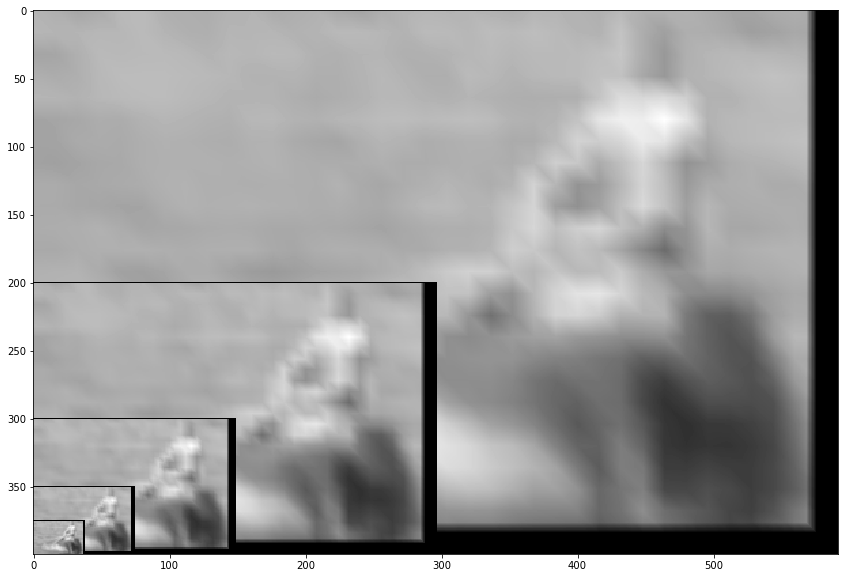

In [50]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize

def interpolate(img):
    new_img = np.zeros((img.shape[0] * 2, img.shape[1] * 2))
    for x in range(img.shape[0]-1):
        for y in range(img.shape[1]-1):
            new_img[x*2][y*2] = img[x][y]
            new_img[x*2+1][y*2] = img[x][y]/2 + img[x+1][y]/2
            new_img[x*2+1][y*2+1] = img[x][y]/2 + img[x+1][y+1]/2
            new_img[x*2][y*2+1] = img[x][y]/2 + img[x][y+1]/2
    
    return new_img

def expand(img, pyramid, steps=1):
    if steps == 0:
        return img, pyramid
    
    interpolated = interpolate(img)
    new_pyramid = interpolated.copy()
    new_pyramid[interpolated.shape[0]-pyramid.shape[0]:, 0:pyramid.shape[1]] = pyramid
    new_pyramid[interpolated.shape[0]-pyramid.shape[0]:, pyramid.shape[1]] = 0
    new_pyramid[interpolated.shape[0]-pyramid.shape[0], :pyramid.shape[1]] = 0
    
    steps -= 1
    
    return expand(interpolated, new_pyramid, steps)
    

img = imread('images/mermaid.png').astype(float)/255
steps = 4

reduced, _ = reduce(img, img.copy(), stop_at=img.shape[0] / (2 ** steps))
_, pyramid_image = expand(reduced, reduced.copy(), steps)

plt.figure(figsize=(15,10))
plt.gray()
plt.imshow(pyramid_image)
plt.show()

## Assignment 3: Texture Segmentation [5 Points]

**a)** What is texture? Try to define it in your own words. Can there be a standard definition? What problems do you expect for texture based segmentation? 

YOUR ANSWER HERE

**b)** What is a co-occurence matrix? How can it be used to characterize texture?

YOUR ANSWER HERE


**c)** Implement a function to compute the co-occurence matrix of an image (patch). Apply it and compare your results to (CV-07 slide 54).

In [ ]:
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import imageio 

img = imageio.imread('images/mermaid.png')#, mode='L')

def get_patch(img, x, y, size=40):
    """
    Extract a rectangular patch from an image and mark it in the original image.
    
    Args:
        img (nndarray): Input image.
        x (uint): X-coordinate.
        y (uint): Y-coordinate.
        size (uint): Size of the patch.
        
    Returns:
        result: The extracted patch.
    """
    result = img[x:x+size,y:y+size].copy()
    img[x:x+size, [y,y+1,y+size,y+size+1]] = 0
    img[[x,x+1,x+size,x+size+1], y:y+size] = 0
    return result

patches = []
patches.append(get_patch(img, 50,130))
patches.append(get_patch(img, 110,80))
patches.append(get_patch(img, 260,340))
patches.append(get_patch(img, 310,110))
patches.append(get_patch(img, 100,440))


def cooccurrence(img, dx=1, dy=1):
    """
    Compute a co-occurence matrix for the given image.
    
    Args:
        img          the grayscale image (uint8)
        dx,dy        the offset between the two reference points

    Returns:
        matrix       the co-occurence matrix
    """
    matrix = np.empty((256, 256))
    # YOUR CODE HERE
    return matrix


plt.figure(figsize=(8, 8))
plt.gray()
plt.imshow(img)
plt.show()


plt.figure(figsize=(8, 8))
i = 0
for p in patches:
    plt.subplot(len(patches),3,i+1); plt.axis('off'); plt.imshow(p)
    # For visualization one may apply some extra me, e.g., logarithmization or binarization
    plt.subplot(len(patches),3,i+2); plt.imshow(np.log(1 + cooccurrence2(p, 0, 1)), interpolation='none')
    plt.subplot(len(patches),3,i+3); plt.imshow(cooccurrence2(p,1,0)>0, interpolation='none')
    i += 3
plt.show()

## Assignment 4: Region merging [5 Points]

Implement the *region merging* algorithm (CV-07 slide 39) and apply it to the image `segments.png` (or some part of it). Use a simple *homogeneity condition*, e.g. that the maximal difference between gray values in a segment is not larger than a given threshold.

Threshold: 14.8


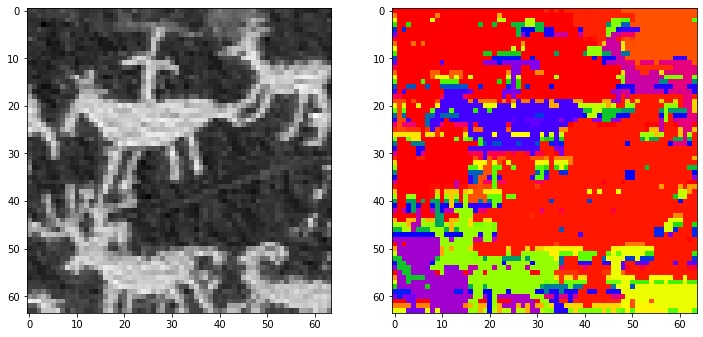

In [70]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import imageio
import warnings
warnings.filterwarnings('ignore')

img = imageio.imread('./images/segments.png', pilmode='L')
# Choosing a large image region lengthens computation time
img = img[64:128,64:128]

thresh = (np.max(img) - np.min(img)) / 10
print('Threshold:', thresh)

neighborhood = [
    (-1,0),(1,0),(0,-1),(0,1)
]

# compute the `label` array by implementing "region merging"
def merge(img):
    i = 0
    labels = np.zeros(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            labels[x][y] = i
            i += 1
            
    while True:
        min_distance = None
        
        already = []
        for lbl in range(img.shape[0] * img.shape[1]):
            segment = np.argwhere(labels == lbl)
            for elem in segment:
                for n in neighborhood:
                    pos = elem + n

                    if not [pos[0],pos[1]] in already:
                        already.append([pos[0],pos[1]])
                        if pos[0] > 0 and pos[1] > 0 and pos[0] < img.shape[0] and pos[1] < img.shape[1]:
                            if labels[pos[0], pos[1]] != lbl:
                                other_seg = np.argwhere(labels == labels[pos[0], pos[1]])

                                trans_seg = np.transpose(segment)
                                trans_other_seg = np.transpose(other_seg)

                                distance = np.abs(np.mean(img[trans_seg[0], trans_seg[1]]) - np.mean(img[trans_other_seg[0], trans_other_seg[1]]))
                                if distance < thresh and (not min_distance or distance < min_distance[0]):
                                    min_distance = distance, trans_seg, trans_other_seg
        if not min_distance:
            break
        else:
            labels[min_distance[2][0], min_distance[2][1]] = labels[min_distance[1][0], min_distance[1][1]][0]
            
    return labels
    
label = merge(img)

plt.figure(figsize=(12, 12))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(label, cmap='prism')
plt.show()


warnings.filterwarnings('ignore')

## Bonus: Painting with a webcam using color detection [0 points]


### Testing your webcam: Images
From now on we will try to make the exercises a bit more interactive and use live feed from your webcam. Unfortunately, using the webcam may not always work out of box (depending on your hardware/os configuration). So first make sure that you can grab an image from the webcam.

1. Use the `imageio` library as presented in the tutorial sessions. You will probably need to install `ffmpeg` packages as shown in the tutorial code.
1. Use the `cv2` library (opencv will use `gstreamer`). You will probably need to install then `opencv` package.

Hint: Sometimes it helps to restart the kernel.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set this flag to either use "imageio" or "cv2"
use_imageio = False
if use_imageio:
    # use imageio for accessing the webcam (requires ffmpeg to be installed on your computer)
    import imageio
    try:
        reader = imageio.get_reader('<video0>')
        img = reader.get_next_data()
        ok = True
        reader.close()
    except:
        ok = False
else:
    # use opencv for accessing the webcam
    import cv2
    camera = cv2.VideoCapture(0)
    ok, img = camera.read()
    camera.release()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if ok:
    plt.imshow(img)
    plt.show()
else:
    print("Accessing your webcam failed.")

### Testing your webcam: Video
You can now test your webcam with video. You can either select the methods presented in the tutorial session, namely `imageio` and `visvis`, or use `cvloop`

**imageio and visvis**


To test these modules run the following code

In [ ]:
import imageio
import visvis as vv
import time 
import numpy as np


reader = imageio.get_reader('<video0>')

img = reader.get_next_data()
res = np.zeros_like(img)

fig = vv.figure() 
a1 = vv.subplot(121)
im_v = vv.imshow(img, clim=(0, 255))
a1 = vv.subplot(122)
res_v = vv.imshow(res, clim=(0, 255))

for im in reader:
    vv.processEvents()     
    im_v.SetData(im)
    res_v.SetData(255 - im)

**cvloop**

Atlernatively you can use `cvloop`. To install `cvloop` first activate your cv environment and then run the follwing cell

In [ ]:
!pip install cvloop

Check that it works by executing the cell below:

In [ ]:
from cvloop import cvloop
cvl = cvloop(function=lambda frame: 255 - frame, side_by_side=True)

### a)
In this task we will track a small colored object (like the cap of a pen) in front of a neutral background of a different color. We will use the location of the object to paint on a virtual canvas. For that you have to implement the following tasks in the `draw_func` function:

* Convert the image `img` given to the `draw_func` into HSV color space. You may use the OpenCV function `cvtColor` or equivalent methods fro skimage. Note: In OpenCV BGR and not RGB is the standard color space.
* Measure the color of your object. You may return the converted image and interactively measure the color with your mouse. Define your measured hue value in a constant
* Discard all channel except the hue channel. 
* Find the location with the most similar hue to the measured hue of your object. You may cast your `uint8` image to `int16`
to allow negative values
* Paint a marker, for example a circle, at this position in `img_draw`.


In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Adapt this hue value to the hue of your object
hue = 52

# A global canvas to draw on
canvas = np.zeros((480,640,3), np.uint8) 

# radius and color of the marker
radius = 5
color = (255,255,255)

def draw_func(img):
    """
    Draw a circle on img_draw at the detected object location.
    
    Args:
        img          the BGR input image (uint8)

    Returns:
        img_draw     img with circle drawn at postion of object
    """
    global canvas, hue, radius, color
    
    # YOUR CODE HERE
    return canvas

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 1))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb = mpl.colorbar.ColorbarBase(ax, cmap=mpl.cm.hsv, orientation='horizontal',
                               norm=mpl.colors.Normalize(vmin=0, vmax=255))
cb.set_ticks([hue])
cb.set_label('the hue value')
plt.show()

In [ ]:
# First test your function with single image and without cvloop (cvloop does not output or error messages
# raised in the callback function). You may either grab an image from your webcam (as described above),
# or choose an arbitrary image from wherever you like

%matplotlib inline
import matplotlib.pyplot as plt

draw_func(img)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(canvas)
plt.show()

In [ ]:
# Now run your function from with imageio and visvis or alternatively with cvloop

import imageio
import visvis as vv
import numpy as np


reader = imageio.get_reader('<video0>')

img = reader.get_next_data()
res = np.zeros_like(img)

fig = vv.figure() 
a1 = vv.subplot(121)
im_v = vv.imshow(img, clim=(0, 255))
a1 = vv.subplot(122)
res_v = vv.imshow(res, clim=(0, 255))

for im in reader:
    vv.processEvents()     
    im_v.SetData(im)
    res_v.SetData(draw_func(im))

In [ ]:

%matplotlib notebook
from cvloop import cvloop

# Now use cvloop to run the algorithm live on webcam data     
cvl = cvloop(function=draw_func, side_by_side=True)